### Import TensorFlow and other libraries


Start by installing [TensorFlow I/O](https://www.tensorflow.org/io), which will make it easier for you to load audio files off disk.

In [3]:
import os
import json
import math
import pickle

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet](http://g.co/audioset) corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`.

The model returns 3 outputs, including the class scores, embeddings, and the log mel [spectrogram](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). You can find more details [here](https://tfhub.dev/google/yamnet/1).

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output.

### Loading YAMNet from TensorFlow Hub

Note: to read the documentation of the model, use the model URL in your browser.

In [4]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

### Load the class mapping

It's important to load the class names that YAMNet is able to recognize. The mapping file is present at `yamnet_model.class_map_path()` in the CSV format.

In [5]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


### Load the dataset

Note: The returned `wav_data` from `load_wav_16k_mono` is already normalized to values in the `[-1.0, 1.0]` range (for more information, go to [YAMNet's documentation on TF Hub](https://tfhub.dev/google/yamnet/1)).

In [6]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
%%time
# using the loading function provided by the tutorial prints a warning message
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

audios_folder = 'data/audios/'
labels_folder = 'data/labels/'
data_21_folder = audios_folder + 'audio_2021/'

data_21 = {}
for name in os.listdir(data_21_folder):
    data_21[name] = load_wav_16k_mono(data_21_folder + name)

len(data_21)

CPU times: user 1min 13s, sys: 2.52 s, total: 1min 15s
Wall time: 1min 35s


237

Test if loading was OK

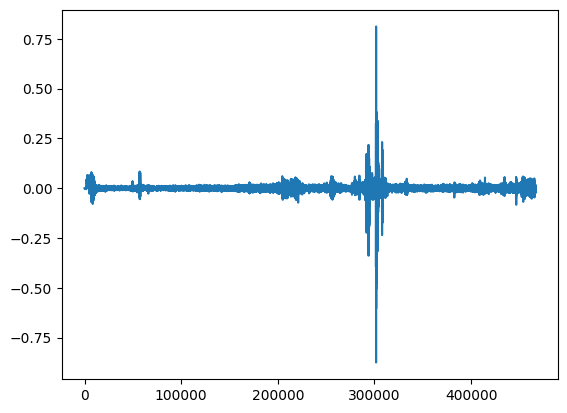

In [8]:
testing_wav_data = list(data_21.values())[0]

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

### Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.

Let's test for a single element first

In [9]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (60, 1024)


In [10]:
scores.shape, tf.reduce_sum(scores, axis=0)[0].numpy()

(TensorShape([60, 521]), 0.6592368)

Entries in scores are not joint probabilities

In [11]:
tf.reduce_min(scores).numpy(), tf.reduce_max(scores).numpy()

(7.262654e-24, 0.8791892)

They can be independent probabilites, i.e. probability that the single event is happening

<Axes: ylabel='Density'>

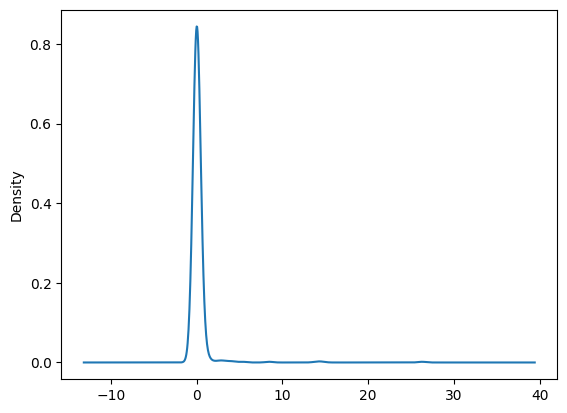

In [12]:
scores_series = pd.Series(tf.reduce_sum(scores, axis=0).numpy())

scores_series.plot.density()

In [13]:
scores_series.describe()

count    5.210000e+02
mean     2.269307e-01
std      1.551276e+00
min      1.061203e-07
25%      3.014512e-04
50%      2.094194e-03
75%      2.383863e-02
max      2.628590e+01
dtype: float64

Run inference on the dataset

In [14]:
%%time
data_21_scores = {id : yamnet_model(el) for id, el in data_21.items()}
len(data_21_scores)

CPU times: user 17.6 s, sys: 121 ms, total: 17.8 s
Wall time: 18.1 s


237

Plot the distribution of the number of splits made by the model for each wav file

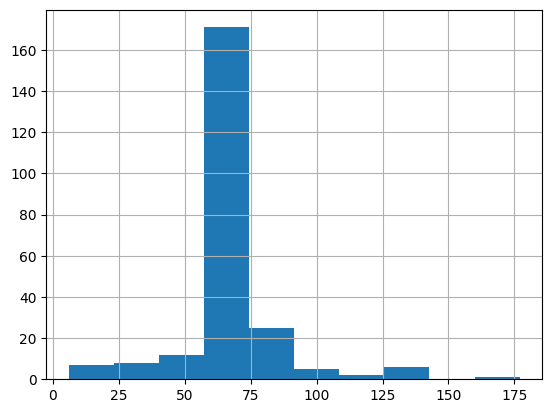

In [15]:
pd.Series([el[0].shape[0] for _, el in data_21_scores.items()]).hist()
plt.show()

### Save the predictions

In [16]:
with open('data/yamnet_scores/yamnet_scores_2021.pickle', 'wb') as handle:
    pickle.dump(data_21_scores, handle)

### Load the labels

In [17]:
with open(labels_folder + 'SAB-AudioTagging-2021.json') as f:
  labels_21 = json.load(f)

In [18]:
len(labels_21)

237

Remember: the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds.

Each label in the json have a list of annotations in the 'segmentations' field. Each annotation has:
- a 'start_time' field, that contains the start time in seconds
- a 'end_time' field, that contains the end time in seconds
- an 'Element' field that contains the actual label (in json_el['segmentations'][i]['annotations']['Element']['values'][0]['value']), with the path in the taxonomy
- a 'Distance field that contains 'Background' or 'Foreground' (in json_el['segmentations'][i]['annotations']['Distance']['values'][0]['value'])



Let's create a function that computes the labels in each frame produced by the model

In [19]:
def create_frame_labels(orig_labels, frame_shift=0.48):   #, frame_duration=0.96):
    frame_lab = {}

    for lab in orig_labels:
        name = lab['original_filename']
        # frame_lab[name] = []  # this will be a list of n_frames lists with string (actual labels)
        frame_lab[name] = {}    # no, it will be a dictionary {n_frame: list of labels} because idk the length of the audio file
        for annot in lab['segmentations']:
            start = annot['start_time']
            end = annot['end_time']
            # the real annotation is in annot['annotations']
            annot = annot['annotations']
            act_lab = annot['Element']['values'][0]['value']
            try:
                dist = annot['Distance']['values'][0]['value']
            except KeyError:
                dist = 'Unknown'
            # compute first and last frames that contain this annotation
            first_frame = math.floor(start / frame_shift)
            last_frame = max(first_frame, math.floor(end / frame_shift) - 1)  # cannot go below first_frame
            ### there is a problem if the annotation end when the video ends
            for i in range(last_frame - first_frame + 1):
                if first_frame + i not in frame_lab[name].keys():
                    frame_lab[name][first_frame + i] = []
                frame_lab[name][first_frame + i].append((act_lab, dist))

    return frame_lab

labels_frames_21 = create_frame_labels(labels_21)

Filter the keys that are not present in the data and check that labels and data share the same keys

---



In [20]:
labels_frames_21 = {key: val for key, val in labels_frames_21.items() if key in data_21.keys()}

In [21]:
len(set(labels_frames_21.keys())), len(set(data_21_scores.keys())), len(set(labels_frames_21.keys()).intersection(set(data_21_scores.keys())))

(237, 237, 237)

We also have to be sure that the maximum of the computed windows in create_frame_labels does not exceed the shape of the predictions. That function does not work if an annotation ends when the video ends (since we don't know video lengths)

In [22]:
for name, (pred, _, _) in data_21_scores.items():
    n_model_frames = pred.shape[0]
    n_lab_frames = max(labels_frames_21[name].keys()) if len(labels_frames_21[name]) > 0 else 0

    if n_lab_frames == n_model_frames:
        labels_frames_21[name].pop(n_lab_frames)

Let's see one example of labels_frame


In [23]:
list(labels_frames_21.values())[0]

{16: [('Human/Voice', 'Background'),
  ('Transport/Motorized/Road', 'Background')],
 17: [('Human/Voice', 'Background'),
  ('Transport/Motorized/Road', 'Background')],
 21: [('Human/Movement/Steps', 'Foreground'),
  ('Transport/Motorized/Road', 'Background')],
 22: [('Human/Movement/Steps', 'Foreground'),
  ('Transport/Motorized/Road', 'Background')],
 25: [('Things/Movement', 'Foreground'),
  ('Transport/Motorized/Road', 'Background')],
 29: [('Industrial/Construction', 'Foreground'),
  ('Transport/Motorized/Road', 'Background')],
 30: [('Industrial/Construction', 'Foreground'),
  ('Transport/Motorized/Road', 'Background')],
 31: [('Industrial/Construction', 'Foreground'),
  ('Transport/Motorized/Road', 'Background')],
 32: [('Industrial/Construction', 'Foreground'),
  ('Transport/Motorized/Road', 'Background')],
 33: [('Industrial/Construction', 'Foreground'),
  ('Transport/Motorized/Road', 'Background')],
 34: [('Industrial/Construction', 'Foreground'),
  ('Transport/Motorized/Road'

### Compare predictions

First we compare only with foregrounds labels

In [24]:
foreground_lab_21 = {}
for name, lab in labels_frames_21.items():
    foreground_lab_21[name] = {}
    for n_frame, annot in lab.items():
        foreground_lab_21[name][n_frame] = [lab for lab, dist in annot if dist=='Foreground']

list(foreground_lab_21.values())[0], len(foreground_lab_21)

({16: [],
  17: [],
  21: ['Human/Movement/Steps'],
  22: ['Human/Movement/Steps'],
  25: ['Things/Movement'],
  29: ['Industrial/Construction'],
  30: ['Industrial/Construction'],
  31: ['Industrial/Construction'],
  32: ['Industrial/Construction'],
  33: ['Industrial/Construction'],
  34: ['Industrial/Construction'],
  35: ['Industrial/Construction'],
  36: ['Industrial/Construction'],
  49: ['Human/Voice', 'Industrial/Construction'],
  50: ['Human/Voice', 'Industrial/Construction'],
  51: ['Human/Voice', 'Industrial/Construction'],
  52: ['Human/Voice', 'Industrial/Construction'],
  53: ['Human/Voice', 'Industrial/Construction'],
  54: ['Human/Voice', 'Industrial/Construction'],
  55: ['Human/Voice', 'Industrial/Construction'],
  56: ['Human/Voice', 'Industrial/Construction'],
  46: ['Industrial/Construction'],
  47: ['Industrial/Construction'],
  48: ['Industrial/Construction'],
  57: ['Industrial/Construction'],
  58: ['Industrial/Construction'],
  59: ['Industrial/Construction'],

Check the possible numbers of labels at the same frame.

Note: YAMNet does not support multiple labels

In [25]:
possible_lab_per_frame = set([len(lab_list) for name, el in foreground_lab_21.items() for lab_list in el.values()])
possible_lab_per_frame

{0, 1, 2, 3, 4}

In [26]:
for name, el in foreground_lab_21.items():
  el1, el2 = max(el.keys()), data_21_scores[name][0].shape[0]
  if el1 >= el2:
    print(name, el1, el2)

Remember: data_21_score = {wav_filename: (model_preds, embedding, spectrograms)}

model_preds shape (n_frames, 521), where 521 is the n of classes on which YAMNet was traines

In [27]:
data = []
for name, el in foreground_lab_21.items():
    for frame_n, lab_list in el.items():
        row = {}
        row['file'] = name
        row['frame_number'] = frame_n
        for i in range(len(possible_lab_per_frame)):
            row[f'label_{i}'] = 'None' if i >= len(lab_list) else lab_list[i]

        pred_index = tf.argmax(data_21_scores[name][0][frame_n])
        row['predicted_label'] = class_names[pred_index]

        data.append(row)

labels_comp_df_21 = pd.DataFrame(data=data)
labels_comp_df_21.head()

,file,frame_number,label_0,label_1,label_2,label_3,label_4,predicted_label
0,028e0b17-0879-44eb-83eb-b5563c18ab0a.wav,16,None,None,None,None,None,Animal
1,028e0b17-0879-44eb-83eb-b5563c18ab0a.wav,17,None,None,None,None,None,Speech
2,028e0b17-0879-44eb-83eb-b5563c18ab0a.wav,21,Human/Movement/Steps,None,None,None,None,Vehicle
3,028e0b17-0879-44eb-83eb-b5563c18ab0a.wav,22,Human/Movement/Steps,None,None,None,None,Vehicle
4,028e0b17-0879-44eb-83eb-b5563c18ab0a.wav,25,Things/Movement,None,None,None,None,Vehicle


In [28]:
labels_comp_df_21.to_csv('data/yamnet_foreground_labels_21.csv', index=False)